# Homework 3: Reward and Error Learning in Motor Adaptation

**Course:** Models of the Motor System 2025-2  
**Instructor:** Opher Donchin  

This homework guides you through implementing a reward-error learning model (Izawa & Shadmehr, 2011) using Kalman filtering and temporal difference learning. You will:
- Generate a perturbation schedule
- Implement core learning steps
- Explore noise parameters to reproduce Figure 4 from the Izawa paper (provided)
- Critically analyze the model's fit to the empirical data

## Part A. Perturbation Schedule

**Task:**  
Generate a step perturbation schedule with:
- N steps, each of a specified step size
- A plateau at the end

Implement the function:

```python
def generate_perturbation_schedule():
    """
    Returns:
        p: numpy array of perturbations across all trials
    """
    # TODO: Implement this function
    # Example: fill steps...
    return p
```


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part A. Perturbation Schedule Implementation

In [3]:
def generate_perturbation_schedule():
    """
    Returns:
        p: numpy array of perturbations across all trials
    """
    # TODO: Implement this function
    p = np.zeros([450,])
    # Placeholder: students fill in correct steps
    return p

## Part B. Implementing the Learning Model

The following function scaffolds the simulation. You must fill in the **Kalman filter update step** and the **reward learning step**.  
We pre-filled noise initialization and overall structure. Initial values are placeholders (zeros) to ensure code runs.

In [5]:
def simulate(p, seed=42, 
             s_y=1.0, s_h=1.0, s_phat=1.0, s_u=1.0, 
             beta=0.001, A_val=0.9, 
             gamma=0.95, alpha_v=0.15, alpha_r=0.04, target_radius=3):
    """
    Simulate reward and error learning.
    """
    A = np.array([[A_val, 0], [1, 0]])
    b = np.array([[0], [1]])
    C = np.array([[1, 1]])
    Q = np.diag([s_phat**2, s_h**2])
    R = np.array([[s_y**2]])

    total_trials = len(p)
    np.random.seed(seed)

    x = np.zeros((2, total_trials))
    u = np.zeros(total_trials + 1)
    x_hat = np.zeros((2, total_trials + 1))
    P = np.zeros((2, 2, total_trials))
    K = np.zeros((2, 1, total_trials))

    c = np.zeros(total_trials)
    y = np.zeros(total_trials)
    r = np.zeros(total_trials)
    delta = np.zeros(total_trials)

    w_v = np.zeros(total_trials + 1)
    w_r = np.zeros(total_trials + 1)

    n_h = np.random.normal(0, s_h, total_trials)
    n_y = np.random.normal(0, s_y, total_trials)
    n_p = np.random.normal(0, s_phat, total_trials)
    n_u = np.random.normal(0, s_u, total_trials)

    for k in range(total_trials):
        # True dynamics
        x[0, k] = p[k]
        x[1, k] = u[k] + n_h[k]
        c[k] = (C @ x[:, k])[0]
        y[k] = c[k] + n_y[k]

        if k == 0:
            x_hat_prev = x_hat[:, 0]
            P_prev = Q
        else:
            x_hat_prev = x_hat[:, k]
            P_prev = P[:, :, k-1]

        x_hat_pred = A @ x_hat_prev + b.flatten() * u[k]
        P_pred = A @ P_prev @ A.T + Q

        S = C @ P_pred @ C.T + R
        K_k = P_pred @ C.T @ np.linalg.inv(S)
        K[:, :, k] = K_k

        residual = y[k] - (C @ x_hat_pred)[0]

        # TODO: Implement Kalman filter update
        x_hat[:, k+1] = np.zeros_like(x_hat[:, k])  # placeholder
        P[:, :, k] = np.zeros_like(P_pred)          # placeholder

        effort = beta * u[k]**2
        r[k] = 1 - effort if abs(c[k]) < target_radius else -effort

        if k > 0:
            # TODO: Implement temporal difference error
            delta[k] = 0  # placeholder
            w_v[k+1] = w_v[k]
            w_r[k+1] = w_r[k]
        else:
            delta[0] = 0
            w_v[1] = w_v[0]
            w_r[1] = w_r[0]

        u[k+1] = -x_hat[0, k] + w_r[k] + n_u[k]
        u[k+1] = np.clip(u[k+1], -90, 90)

    return pd.DataFrame({
        'trial': np.arange(total_trials),
        'x_p': x[0, :],
        'x_h': x[1, :],
        'c': c,
        'y': y,
        'x_hat_p': x_hat[0, :total_trials],
        'x_hat_h': x_hat[1, :total_trials],
        'u': u[:total_trials],
        'w_r': w_r[:total_trials],
        'w_v': w_v[:total_trials],
        'r': r,
        'delta': delta
    })

## Part C. Simulating Different Conditions

We provide parameters except the noise levels.  
**Task:**  
- Choose noise levels appropriate to reproduce Figure 4 (attached).
- Run three conditions:
    - ERR
    - EPE
    - RWD

In [6]:
# Example placeholder values — students should choose realistic ones

# Perturbation schedule
p = generate_perturbation_schedule()

# Run simulations
df_ERR = simulate(p, s_y=1.0, s_h=1.0, s_phat=1.0, s_u=1.0)
df_EPE = simulate(p, s_y=1.0, s_h=1.0, s_phat=1.0, s_u=1.0)
df_RWD = simulate(p, s_y=1.0, s_h=1.0, s_phat=1.0, s_u=1.0)

## Part D. Plotting Results

This cell plots the reach angle and learning weights across trials for each condition (ERR, EPE, RWD).

The learning weights are:
- wr: reward-based learning
- we: error-based learning (interpreted as wv here)
- wr + we: total learning

Colors:
- Black: reach angle
- Red: wr
- Blue: we
- Purple: wr + we

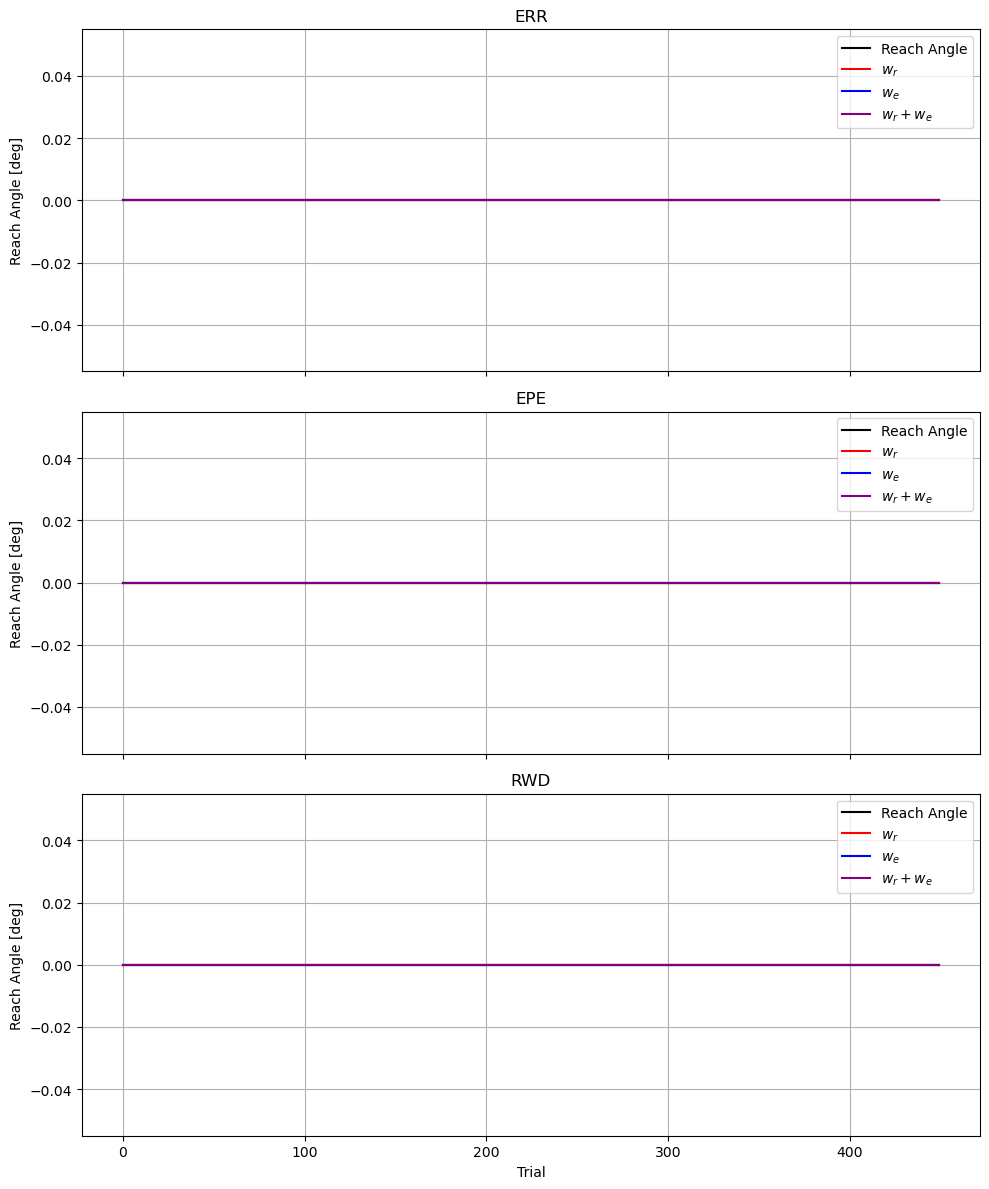

In [7]:
colors = {
    'reach': 'black',
    'wr': 'red',
    'we': 'blue',
    'sum': 'purple'
}

# Create figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

conditions = ['ERR', 'EPE', 'RWD']
dataframes = [df_ERR, df_EPE, df_RWD]

for ax, df, cond in zip(axs, dataframes, conditions):
    # Reach angle (estimated hand position)
    ax.plot(df['trial'], df['x_hat_h'], color=colors['reach'], label='Reach Angle')
    
    # Learning weights
    ax.plot(df['trial'], df['w_r'], color=colors['wr'], label='$w_r$')
    ax.plot(df['trial'], df['w_v'], color=colors['we'], label='$w_e$')
    ax.plot(df['trial'], df['w_r'] + df['w_v'], color=colors['sum'], label='$w_r + w_e$')
    
    # Labels and title
    ax.set_title(cond)
    ax.set_ylabel('Reach Angle [deg]')
    ax.grid(True)
    ax.legend()

# Common x-label
axs[-1].set_xlabel('Trial')

# Adjust layout
plt.tight_layout()
plt.show()

## Part E. Discussion

**Questions:**
1. Did you manage to reproduce Figure 4? Which noise level is manipulated in each condition?
2. Do you find the model’s predictions convincing? Why or why not?
3. If you choose different (more realistic) noise levels, how does that change your opinion of the model?

---

**Submission Instructions:**
- Submit your `.ipynb` notebook on Moodle.
- Ensure all code cells run without error.
- Answer all discussion questions.